# Reading Shapefiles from a URL into GeoPandas


Shapefiles are probably the most commonly used vector geospatial data format. However, because a single Shapefile consists of multiple files (at least 3 and up to 15) they are often transferred as a single zip file. In this post I demonstrate how to read a zipped shapefile from a server into a GeoPandas GeoDataFrame (with coordinate reference system information), all in memory.

This is probably not the most exciting post - no interesting visuals or cool data to play with - but I did find it to have great utility. In addition to now having a quick tool for reading in geospatial data directly from the web, it also helped me better understand how to work across and between various geospatial data types in Python. 

In writing this procedure, I supplemented code from [this](http://geospatialpython.com/2011/09/reading-shapefiles-from-cloud.html) blog post that demonstrates how to read a zipped Shapefile into a ```PyShp``` object.

I then demonstrate how this code can be used to read in U.S. County geographic boundaries from the [Census FTP site](http://www2.census.gov).

In [45]:
from urllib2 import urlopen
from zipfile import ZipFile
from StringIO import StringIO
import shapefile
import geopandas as gpd
from shapely.geometry import shape  
import osr
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline

The first step is to use ```PyShp``` to read in our Shapefile. If we were just reading a Shapefile from disk we would simply call: 

```
r = shapefile.Reader("myshp.shp")
```

However, because we are reading our Shapefile from a zipfile, we will need to specify the individual components of this file. Unfortunately, we can't read the contents of a zipfile directly into Python from the URL. While we could have Python download the file to disk and then read it in from there, I want to demonstrate how this can be done all in memory without any disk activity. Therefore we need to take an additional step where the data from the URL is read into a ```StringIO``` object, which is in turn read by Python as a zip file. The ```StringIO``` object is just an intermediate data type between the data read in from the URL and the zip file in Python. This is done in one line of code below:

In [38]:
#specify zipped shapefile url
county_file_url = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_us_county_500k.zip'

zipfile = ZipFile(StringIO(urlopen(county_file_url).read()))

Now this zipfile object can be treated as any other zipfile that was read in from disk. Below I identify the filenames of the 4 necessary components of the Shapefile. Note that the ```prj``` file is actually not 100% necessary, but in contains the coordinate reference system information which is really nice to have, and will be used below.

In [22]:
filenames = [y for y in sorted(zipfile.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print filenames

['cb_2015_us_county_500k.dbf', 'cb_2015_us_county_500k.prj', 'cb_2015_us_county_500k.shp', 'cb_2015_us_county_500k.shx']


Next, I create variables for these 4 files. Once again, because I am not reading them to the disk, I need to have these files as ```StringIO``` objects so that they can be passed to the shapefile reader in memory. Now I have a ```PyShp``` reader object that was read in directly from a server. Note that ```PyShp``` reader objects do not store coordinate reference information, which is why the ```prj``` file was not specified yet. However, that will come into play later.

The ```PyShp``` reader object stores all of the geographic information and attributes that from the Shapefile. Below I print the number of records, showing that there are 3,233 counties in the U.S.

In [23]:
dbf, prj, shp, shx = [StringIO(zipfile.read(filename)) for filename in filenames]

r = shapefile.Reader(shp=shp, shx=shx, dbf=dbf)
print r.numRecords

3233


Now I will extract all of the data from the ```PyShp``` reader object and put it in a form that can be read by GeoPandas. For the geometry this will be a list of ```shapely``` geometry objects, and for the attributes this will be a list of dictionaries containing field names and field values.

Obtaining the attributes for each record is straightforward, but extracting the geometry is a bit more complicated, and I again need to use an intermediate data structure. Each record's geometry has a ```__geo_interface__``` property which is just a standardized way of interfacing with geographic data in Python. The interface returns data as GeoJSON, which is compatible with most other libraries, including ```shapely``` which I use below to convert the GeoJSON to a ```shapely``` geometry object. Below I print an example of the GeoJSON before it is converted.

In [40]:
attributes, geometry = [], []
field_names = [field[0] for field in r.fields[1:]]  
for row in r.shapeRecords():  
    geometry.append(shape(row.shape.__geo_interface__))  
    attributes.append(dict(zip(field_names, row.record)))  
    
print row.shape.__geo_interface__

{'type': 'Polygon', 'coordinates': (((-101.629396, 34.750056), (-101.628055, 34.831755), (-101.627886, 34.84239), (-101.627507, 34.865974), (-101.627861, 34.875054999999996), (-101.626376, 34.929653), (-101.625989, 34.971753), (-101.625853, 34.985783), (-101.62516, 34.993724), (-101.625011, 35.015087), (-101.622941, 35.183116999999996), (-101.615379, 35.183239), (-101.61403, 35.183157), (-101.611241, 35.183232), (-101.37586, 35.182066), (-101.328954, 35.182009), (-101.311473, 35.182072), (-101.182259, 35.181708), (-101.086281, 35.18214), (-101.086739, 35.136099), (-101.086875, 35.080059), (-101.087278, 35.027079), (-101.088474, 34.957916), (-101.089331, 34.875052), (-101.089237, 34.874243), (-101.090753, 34.749809), (-101.090749, 34.748246), (-101.199931, 34.747704), (-101.279481, 34.748267), (-101.385871, 34.748377), (-101.434904, 34.74742), (-101.471562, 34.747462), (-101.629257, 34.747648999999996), (-101.629396, 34.750056)),)}


At this point, I have constructed a list of record attributues and a list of record geometries. Lastly I will use the Shapefile's ```prj``` file to get the coordinate reference system so that this can be specified when creating the ```GeoDataFrame```. PRJ files are simply text files that contain a string of information related to the coordinate reference system. However, the contents of a ```prj``` file cannot be read directly in GeoPandas. GeoPandas can, however, read in [proj4](https://en.wikipedia.org/wiki/PROJ.4) strings, which are just another way of referencing this information.

I can easily convert the contents of the ```prj``` file to a proj4 string using ```osr```, which I do below.


In [25]:
proj4_string = osr.SpatialReference(prj.read()).ExportToProj4()
print proj4_string

+proj=longlat +ellps=GRS80 +no_defs 


Now I have all of the components to construct a GeoDataFrame. I specify the attributes (a list of dictionaries), the geometry (a list of ```shapely``` geometries), and the coordinate reference system (a proj4 string).

In [26]:
gdf = gpd.GeoDataFrame(data = attributes, geometry = geometry, crs = proj4)
print gdf.head()

         AFFGEOID       ALAND    AWATER COUNTYFP  COUNTYNS  GEOID LSAD  \
0  0500000US01005  2291820706  50864677      005  00161528  01005   06   
1  0500000US01023  2365954971  19059247      023  00161537  01023   06   
2  0500000US01035  2201896058   6643480      035  00161543  01035   06   
3  0500000US01051  1601876535  99850740      051  00161551  01051   06   
4  0500000US01065  1667804583  32525874      065  00161558  01065   06   

      NAME STATEFP                                           geometry  
0  Barbour      01  POLYGON ((-85.748032 31.619181, -85.745435 31....  
1  Choctaw      01  POLYGON ((-88.47322699999999 31.893856, -88.46...  
2  Conecuh      01  POLYGON ((-87.42720399999999 31.26436, -87.425...  
3   Elmore      01  POLYGON ((-86.41333499999999 32.750591, -86.37...  
4     Hale      01  POLYGON ((-87.870464 32.762442, -87.868184 32....  


Below, I extract only those counties in New Jersey (my home state), reproject them to a NJ-specific coordinate reference system, and make a quick plot.

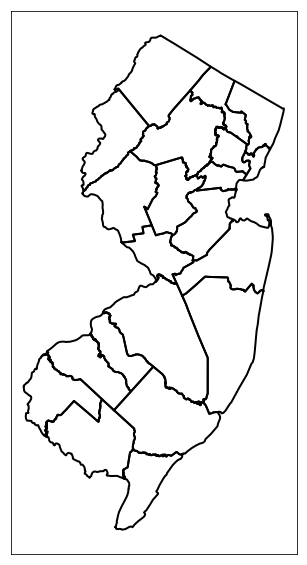

In [50]:
nj = gdf[gdf.STATEFP=='34'].to_crs(epsg = 3424)
ax = nj.plot(color = 'white', figsize=(10,10), linewidth=2)
ax.set(xticks=[], yticks=[])

plt.savefig("NJ_Counties.png", bbox_inches='tight')